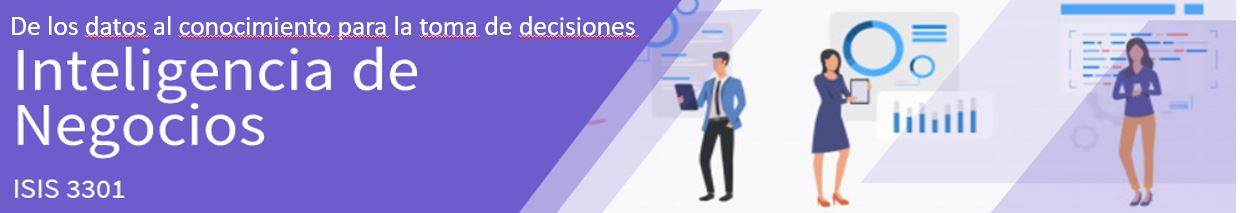

## Tarea de Regresión

Con este cuaderno volvemos a la rama de aprendizaje supervisado, trabajando ahora con una variable objetivo continua. Para esto, vamos a utilizar regresiones lineales que, como vimos en clase, nos permiten predecir una variable continua utilizando otras variables numéricas en los datos.

## Caso

SpotiAlpes quiere desarrollar una herramienta que permita predecir que tan *bailable* es una canción. Esta característica quiere utilizarse para realizar listas de reproducción automáticas y recomendar mejores canciones a sus usuarios. Aunque en el pasado esta variable era extraída por expertos, debido al volumen de nuevas canciones que recibe la empresa, es necesario encontrar una forma de hacer esto de forma automática. Usted ha sido contratado para desarrollar un modelo que asigne automáticamente la *bailabilidad* de una canción según los otros valores disponibles.

A usted se le entregará un conjunto con valores históricos etiquetados y otro reciente sin etiquetar. Se pretende que usted use el modelo para etiquetar los datos recientes.

## 1. Carga de librerías necesarias para implementación

In [1]:
seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse

# q-q plots
import scipy.stats as stats

## 2. Cargar y limpieza de los datos

In [39]:
# Se cargan los datos. 
df_original = pd.read_csv('data/PrepTracksRegresionHistoricos.csv')
df_tracks = df_original.copy()
print(df_tracks.shape)
df_tracks.head(5)

(99500, 22)


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,decibel_range,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,first_artist,second_artist
0,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0.0,181640,0.0,"[""Ignacio Corsini""]",['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.155052,17.7,...,NaN,0.0512,0.994,0.0218,0.2120,0.457,130.418,5.0,Ignacio Corsini,NaN
1,0Dd9ImXtAtGwsmsAD69KZT,La Butte Rouge,0.0,134467,0.0,"[""Francis Marty""]",['2nuMRGzeJ5jJEKlfS7rZ0W'],Year 1922,0.200330,35.5,...,NaN,0.1240,0.965,0.0000,0.1550,0.727,85.754,5.0,Francis Marty,NaN
2,0PH9AACae1f957JAavhOl2,Lazy Boi,0.0,157333,0.0,"[""Uli""]",['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.171900,46.0,...,NaN,0.4530,0.521,0.8560,0.4360,0.402,87.921,4.0,Uli,NaN
3,1MD0Obbza9l0t0Zpgcwagy,And Mimi,0.0,186147,0.0,"[""Dick Haymes"", ""Gordon Jenkins"", ""His Orchest...","['3BiJGZsyX9sJchTqcSA7Su', '58wzyK6DupVsypvs3Q...",Year 1922,0.135240,22.3,...,NaN,0.0453,0.980,0.0813,0.3450,0.226,77.234,3.0,Dick Haymes,Gordon Jenkins
4,1PGLk4jyXA8oWTBtMyYlwX,El Huerfano - Remasterizado,0.0,171013,0.0,"[""Ignacio Corsini""]",['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.191931,11.9,...,NaN,0.0793,0.996,0.8800,0.0773,0.407,122.895,4.0,Ignacio Corsini,NaN


In [40]:
df_recent = pd.read_csv('data/PrepTracksRegresionRecientes.csv')
print(df_recent.shape)
df_recent.head(5)

(500, 21)


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,energy,loudness,...,decibel_range,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,first_artist,second_artist
0,5kO4pdTQURl70Nz9qpmbAO,Raat Ke Hamsafar,22.0,335720,0.0,"[""Asha Bhosle"", ""Mohammed Rafi""]","['5as8A4G47Ohu9NSWs3Je8U', '0gXDpqwYNDODn7fB0R...",1967-12-01,39.4,-13.941,...,NaN,0.0360,0.9810,0.72600,0.2010,0.570,103.129,4.0,Asha Bhosle,Mohammed Rafi
1,29bOAzAR0Ev2UVSa9rkyts,Dum av dig,47.0,224640,0.0,"[""Daniel Adams-Ray""]",['4C86wrjOUfXQDlt6A4oJOC'],2010-01-01,92.5,-5.364,...,NaN,0.1410,0.0804,0.00000,0.0710,0.632,143.094,4.0,Daniel Adams-Ray,NaN
2,6VKR2KNLWUDkNYNC22mrTX,Cammina Nel Sole,41.0,265773,0.0,"[""Gianluca Grignani""]",['0H1InhXaXQPL1aj0mvHemU'],2008-01-01,61.3,-5.898,...,NaN,0.0320,0.2320,0.00000,0.0901,0.136,141.904,4.0,Gianluca Grignani,NaN
3,05lJPd4iOHAV2U1bIM1RZm,Train To Nowhere,18.0,132973,0.0,"[""The Champs""]",['3yt4IVDHz0luREG9Uf9xrp'],1958-01-01,42.4,-20.068,...,NaN,0.0320,0.6780,0.33500,0.1500,0.856,142.041,4.0,The Champs,NaN
4,2cIGKEmlDwQH8DV2t9xHmM,Прирожденные Убийцы,38.0,138621,1.0,"[""ATL""]",['2n6CVwo43YvjiTgcPxYWrf'],2015-02-11,62.8,-5.170,...,NaN,0.0439,0.4100,0.00003,0.1080,0.295,116.139,4.0,ATL,NaN


## 3. Perfilamiento y Entendimiento de los Datos 

Para las regresiones lineales, es necesario trabajar con variables numéricas. En este caso vamos unicamente a seleccionarlas, pero recuerde que existen técnicas para convertir variables categóricas a numéricas que también funcionan en este contexto

In [41]:
df_num = df_tracks.select_dtypes(['number']).copy()
df_num.describe()

,popularity,duration_ms,explicit,danceability,energy,loudness,decibel_range,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,99410.000000,9.950000e+04,99408.000000,99307.000000,99407.000000,99394.000000,155.000000,99401.000000,99412.000000,99400.000000,99407.000000,99400.000000,99399.000000,99410.000000
mean,27.478272,2.324476e+05,0.045811,0.219971,54.229423,-10.150480,47.709677,0.092132,0.449460,0.114156,0.209561,0.551962,118.659451,3.880304
std,18.482615,1.250428e+05,0.209076,0.075458,25.255016,5.066246,29.896785,0.151243,0.349985,0.266842,0.181279,0.258899,29.707725,0.456177
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1.776000e+05,0.000000,0.166274,34.400000,-12.803000,21.000000,0.033800,0.094900,0.000000,0.097600,0.343000,95.878000,4.000000
50%,27.000000,2.160650e+05,0.000000,0.212926,55.000000,-9.181000,49.000000,0.043700,0.420000,0.000029,0.136000,0.564000,117.683000,4.000000
75%,41.000000,2.646432e+05,0.000000,0.267896,74.900000,-6.457250,73.500000,0.072800,0.787000,0.011100,0.269000,0.772000,136.513500,4.000000
max,90.000000,4.685927e+06,1.000000,1.000000,100.000000,2.572000,99.000000,0.971000,0.996000,1.000000,1.000000,1.000000,243.759000,5.000000


In [42]:
# Eliminamos los registros que tienen la variable objetivo nula
df_tracks = df_tracks.dropna(subset = ['danceability'])

### 3.1 Búsqueda de relaciones entre variables (diagramas de dispersión)

Buscamos cuales de las columnas tienen una *relacion* con danceability

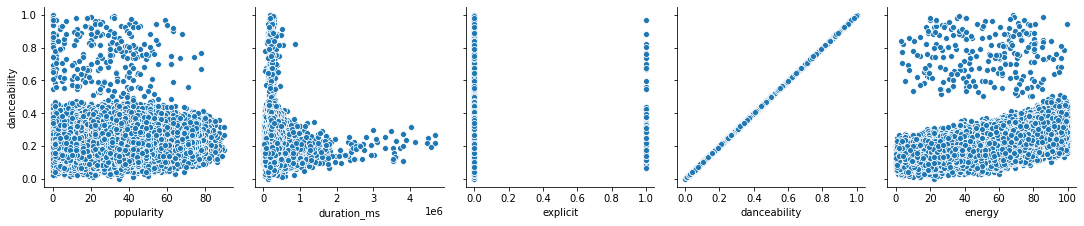

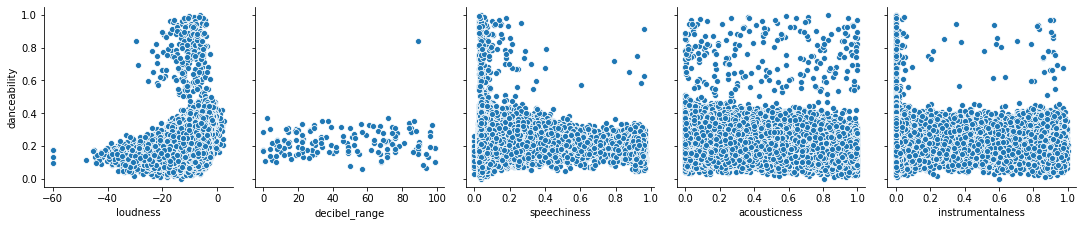

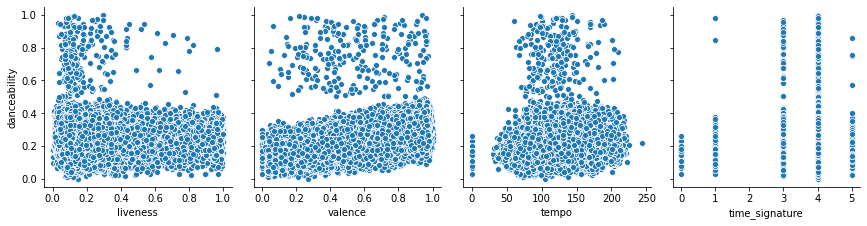

In [43]:
sns.pairplot(df_num, height=3, y_vars = 'danceability', x_vars = df_num.columns[0:5], kind='scatter')
sns.pairplot(df_num, height=3, y_vars = 'danceability', x_vars = df_num.columns[5:10], kind='scatter')
sns.pairplot(df_num, height=3, y_vars = 'danceability', x_vars = df_num.columns[10:], kind='scatter')


De las graficas anteriores vemos que unos buenos candidatos son:
* energy
* loudness
* acousticness
* valence

### 3.2 Búsqueda de relaciones entre variables (Matriz de correlaciones)

Buscamos cuales de las columnas tienen una *relacion* con danceability pero ahora usando correlaciones

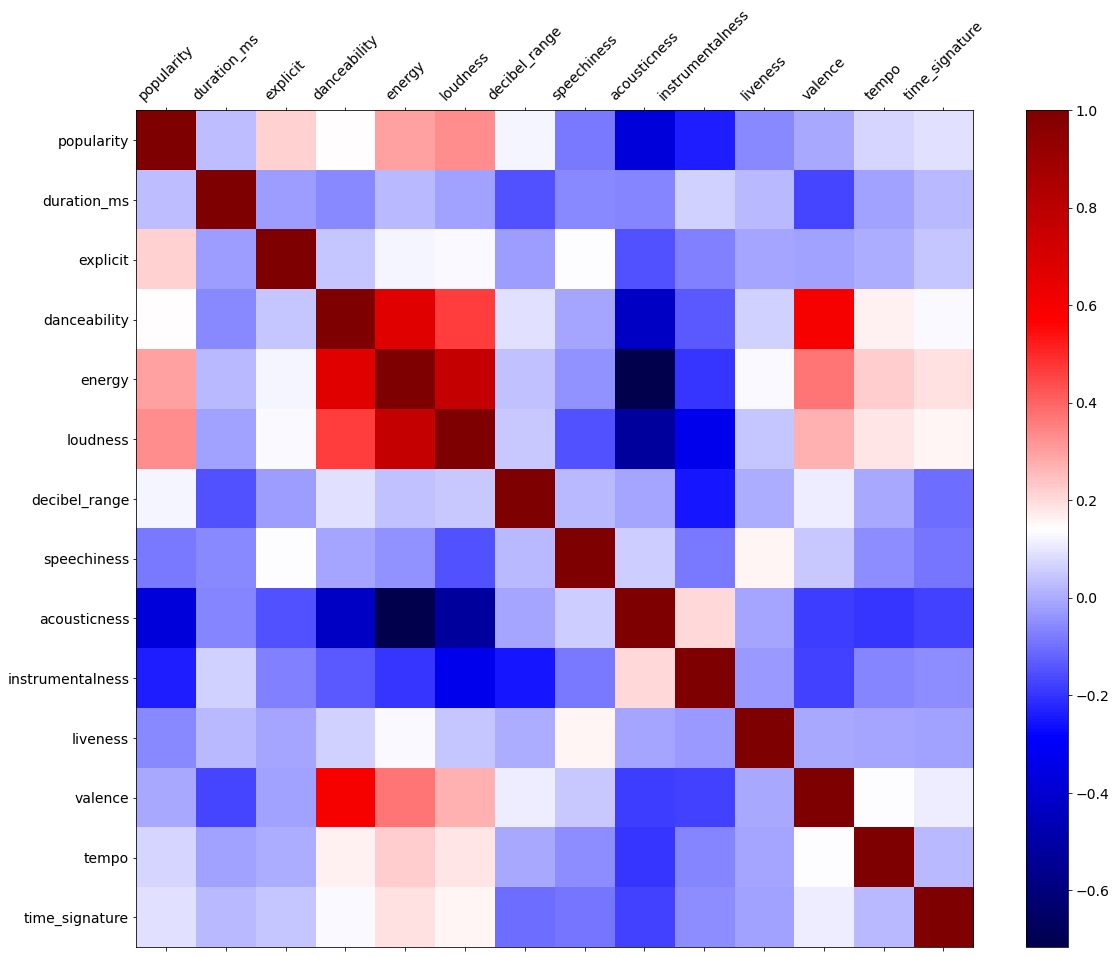

In [44]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_num.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_num.select_dtypes(['number']).shape[1]), df_num.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)


Este método arroja valores similares

## 4.Regresión Básica
Realizamos una regresión básica y luego la utilizamos para asignar la columna *danceability* de los datos recientes.

Se quiere generar un unico modelo que podamos exportar y que pueda ser usado en producción para asignar nuevos valores

In [45]:
# Preprocesamiento
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['energy','loudness','acousticness','valence']

pre = [('initial',ColumnTransformer([("selector", 'passthrough', selected_cols)])),]


In [46]:
# Modelo
model = [('model', LinearRegression())]

In [47]:
# Decalra el pipeline
pipeline = Pipeline(pre+model)

In [48]:
pipeline

Pipeline(steps=[('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['energy', 'loudness',
                                                   'acousticness',
                                                   'valence'])])),
                ('model', LinearRegression())])

In [49]:
# Extraemos las variables explicativas y objetivo para entrenar
df_tracks = df_tracks[['energy','loudness','acousticness','valence', 'danceability']]
X = df_tracks.drop('danceability', axis = 1)
y = df_tracks['danceability']



pipeline = pipeline.fit(X,y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Visualizamos la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):

    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X[col]
    # Pendiente
    m = pipeline['model'].coef_[pos_col]
    # Interceto
    b = pipeline['model'].intercept_

    axs[i].plot(x, y, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)


## 5. Exportar e Importar el Modelo 

In [ ]:
# Usamos la lbreria joblib
filename = 'pipeline.joblib'
# Se guarda
dump(pipeline, filename) 

In [ ]:
# Se lee
p2 = load(filename)
p2

In [ ]:
# Clasificamos los datos recientes
df_recent['danceability'] = p2.predict(df_recent)

In [ ]:
sns.histplot(df_recent['danceability'])

## 6. Coeficientes

Los coeficientes de la regresión nos pueden dar información sobre la relación entre las variables observadas y la variable objetivo.

**Recuerde** La validez de estos coeficientes depende de que se cumplan correctamente las suposiciones de una regresión lineal.

In [ ]:
pipeline['model'].coef_

In [ ]:
# En DataFrame
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

Note que **NO** hemos transformado las variables observadas. ¿Que sucede con los coeficientes si las columnas no se encuentran todas en la misma escala?

**Ejercicio**:  
Agregue un transformador a la parte de preprocesamiento del pipeline para reescalar todas las columnas para que se encuentren entre 0 y 1.

Ayuda: puede usar la clase *MinMaxScaler* de *sklearn.preprocessing*.


In [ ]:
# TODO


In [ ]:
# Vuelve a imprimir los coeficientes
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})


¿Qué cambió?

## 7. Métricas de un Modelo

### 7.1 Coeficiente de Determinación $R^2$

La primera métrica que tenemos es el coeficiente de determinación ($R^2$). Este valor indica que porcentaje de la varianza en la variable objetivo se puede explicar con las variables observadas. Este se define como:
$$ R^2 =  1 - \frac{\sum_{i=1}^{n} (y_i - f_i)^2}{\sum_{i=1}^{n} (y_i - \hat{y})^2}$$

donde $y_i$ es el elemento $i$ de la varaible objetivo, $f_i$ el elemento i de los valores predecidos y:

$$ \hat{y} = \frac{1}{n} \sum_{i=1}^{n} y_{i} $$

In [ ]:
p2.score(X,y)

¿Cómo podemos interpretar este valor?

### 7.2 Root-Mean-Square Error (RMSE) 
La segunda medida es la raiz del error cuadrático medio, definido como:

$$ RSME = \sqrt{\frac{\sum_{i=1}^{n} (y_i - f_i)^2}{n}} $$

In [ ]:
y_true = y
y_predicted = p2.predict(X)

# Note que hay que sacarle la raiz al valor
np.sqrt(mse(y_true, y_predicted))

¿Cómo podemos interpretar este valor?

## 8. Supuestos de la Regresión Lineal

### 8.1 Colinealidad
Es necesario que las columnas utilizadas no tengan (o tengan muy poca) colinealidad. La forma mas sencilla de hacer esto es con la matriz de correlación

In [ ]:
df_temp = df_tracks[selected_cols]


f = plt.figure(figsize=(5, 5))
plt.matshow(df_temp.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_temp.select_dtypes(['number']).shape[1]), df_temp.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_temp.select_dtypes(['number']).shape[1]), df_temp.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)

Vemos que existe una alta colinealidad entre *energy*, *loudness* y *acousticness*.

**Ejercicio:**  
Revisar que sucede con el $R^2$ al utilizar unicamente una de las tres columnas con alta colinealidad. ¿Cuál de las columnas es mejor si se usa individualmente?¿Qué ventajas tiene una regresión con pocas variables explicativas? 

In [ ]:
# TODO

### 8.2 Linealidad
Es necesario que la relación entre cada variable explicativa y la varable objetivo sea lineal. Muchas veces la mejor forma de ahcer esto es visualmente:
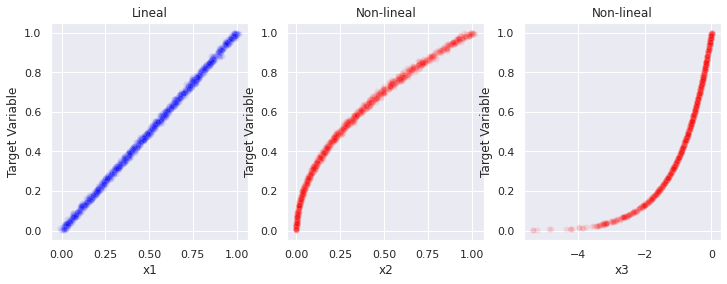

In [ ]:
sns.pairplot(df_tracks, height=3, aspect = 2, y_vars = 'danceability', x_vars = ['energy','valence'], kind='scatter', plot_kws = {'alpha':0.1})

¿Será que energy y danceability tienen una relación no lineal?

In [ ]:
# Revisamos

# Creamos la variable
X = df_tracks[['energy']].copy()
X['energy_2'] = X['energy']**2

# columna
col = 'energy_2'

pre = [('initial',ColumnTransformer([("selector", 'passthrough',[col])])),
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
       ('scaler', MinMaxScaler())]

model = [('model', LinearRegression())]

p_temp = Pipeline(pre+model)

p_temp = p_temp.fit(X,y)

print(f"{col}: {p_temp.score(X,y)}")

### 8.3 Normalidad en los Errores

Otra suposición de la regresión lineal es que los errores tienen una distribución normal. Para esto se puede usar:
* Grafico de dispersión entre los errores y el valor predicto
* Grafico Q-Q

**Dispersión**
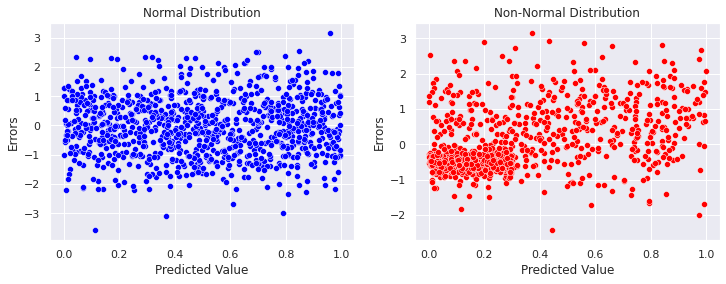

**Q-Q Plots**
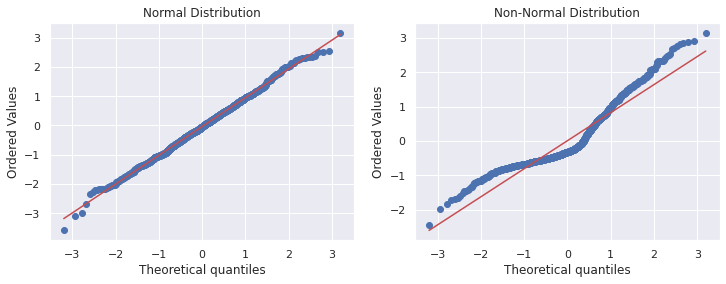

Veamos a ver como se ven estos graficos sobre nuestros datos

In [ ]:
X = df_tracks.drop('danceability', axis = 1)
y = df_tracks['danceability']

# Calculamos los errores
errors = (p2.predict(X) - y).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = p2.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

Una buena estrategia para esto es buscar valores atipicos en la variable objetivo y removerlos del conjunto de entreno.

In [ ]:
# Diagrama de caja
fig=plt.figure(figsize=(12,4))
ax = sns.boxplot(data= df_tracks[['danceability']], orient="h")

**Ejercicio**:  
Elimine los valores atipicos superiores en la variable objetivo y genere un nuevo estimador que utilice las columnas: *energy* y *valence*. Guarde el estimador en una variable llamda *p3*.

In [ ]:
# TODO

In [ ]:

# Calculamos los errores
errors = (p3.predict(X) - y).values

fig, axes = plt.subplots(1, 2, figsize = (12,4))

# Dispersión
sns.scatterplot(x = p3.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

### 8.4 Varianza Constante (Homocedasticidad)

Esta suposición exige que la varianza en los errores se mantenga constante a medida que varia la variable objetivo. Al igual que otras suposiciones anteriores, la mejor forma de identificar esto es visualmente, graficando la variable objetivo contra los errores. 

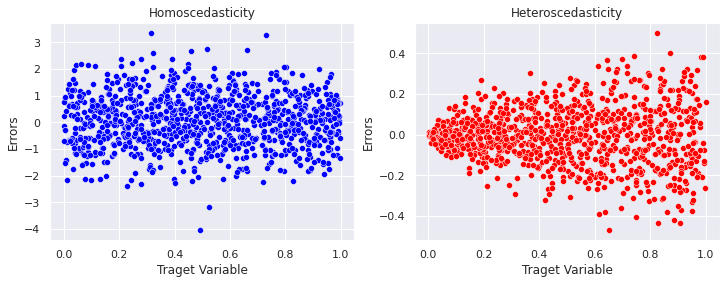

In [ ]:
# Visualizamos nuestros datos
sns.scatterplot(data  = df_clean, x = 'danceability', y = errors, alpha = 0.1)

Una mala grafica puede indicar que se necesita una transformación, o que hace falta una variable extra.

**Ejercicio**:  
Cree un nuevo estimador que incorpore transformaciones polinomiales de las variables de entrada. Es decir, que incluya por ejemplo *energy* al cuadrado, *valence* al cuadrado y *energy* por *valence*. Llame este nuevo estimador *p4*. Recuerde entrenarlo con los datos sin valores atipicos *df_clean*

Ayuda: puede usar la clase *PolynomialFeatures* de *sklearn.preprocessing*.

In [ ]:
# TODO

In [ ]:
# Revisamos las graficas

# Calculamos los errores
errors = (p4.predict(X) - y).values

fig, axes = plt.subplots(1, 3, figsize = (14,4))

# Dispersión
sns.scatterplot(x = p4.predict(X), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

sns.scatterplot(data  = df_clean, x = 'danceability', y = errors, alpha = 0.1, ax = axes[2])

## 9 Final
Usamos el último estimador (el mejor) para clasificar los datos recientes

In [ ]:
df_recent.drop('danceability', axis = 1, inplace = True)
df_recent['danceability'] = p4.predict(df_recent)
sns.histplot(df_recent['danceability'])